## Baseline for Hierarchical Anchor-free Object Detection for Typical and Atypical Mitosis Subtyping

In [1]:
%load_ext autoreload
%autoreload 2
run=1

In [2]:
import torch
import pickle
import numpy
from SlideRunner_dataAccess.database import Database
import pytorch_lightning as pl
import albumentations as A

from src.datamodule import MitosisDataModule
from src.fcos.litmodel import LitFCOS
from src.fcos.model import make_fcos_model

import wandb


## Build annotations dictionary

We train on the MIDOG 2021 dataset. For increased data diversity, we also use the (non-public) test set for training.

In [3]:
db = 'databases_atypia/MIDOG.sqlite'
DB = Database().open(db)
annotations_dict = {}
classes = {x:y for x,y,_,_ in DB.getAllClasses() }
databases_directories = [['databases_atypia/MIDOG.sqlite', 'images_midog_training/'],
                         ['databases_atypia/MIDOG_preliminaryTest.sqlite', 'images_midog_preliminarytest/'],
                         ['databases_atypia/MIDOG_final_TestSet.sqlite', 'images_midog_finaltest/']]

annotations_dict={}
class_mapping = { 'mitotic figure' : 1,
                  'Mitosis - AMF OTHER': 2,
                  'Mitosis - AMF BIPOLAR ASYMMETRIC CAN ALSO HAVE SEGREGATION': 2,
                  'Mitosis - AMF MULTIPOLAR ASYMMETRY CAN ALSO HAVE SEGREGATION': 2,
                  'Mitosis - AMF SEGREGATION ONLY':2,
                  'Mitosis - RING SHAPE (PROMETAPHASE OR METAPHASE)': 3,
                  'Mitosis - NORMAL ANAPHASE-TELOPHASE': 4,
                  'Mitosis - NORMAL PROMETAPHASE': 5,
                  'Mitosis - NORMAL METAPHASE': 6
                }

subclass_names = ['Background', 'N/A','AMF', 'RING SHAPE', 'ANAPHASE-TELOPHASE','PROMETAPHASE','METAPHASE']
value_to_class_DB = {y:x for x,y,_,_ in DB.getAllClasses() }
value_to_class = {x:y for x,y in enumerate(subclass_names) }

for dbfile, folder in databases_directories:
    DB.open(dbfile)
    for uid, fname in DB.listOfSlides()[0:150]:
        fname = folder+fname
        DB.loadIntoMemory(uid)
        annotations_dict[fname] = {}
        for annoI in DB.annotations:
            anno = DB.annotations[annoI]
            if (value_to_class_DB[anno.agreedClass] not in class_mapping): # skip non-mitotic figures
                cls = -2
            else:
                cls = class_mapping[value_to_class_DB[anno.agreedClass]]
            annotations_dict[fname][annoI] = {'x': [int(anno.x1-25),int(anno.x1+25)], 'y': [int(anno.y1-25), int(anno.y1+25)], 'class': cls}



This is how we represent the classes in a flattened vector:

In [4]:
value_to_class

{0: 'Background',
 1: 'N/A',
 2: 'AMF',
 3: 'RING SHAPE',
 4: 'ANAPHASE-TELOPHASE',
 5: 'PROMETAPHASE',
 6: 'METAPHASE'}

In [5]:
wandb.init(entity="imi", project="HFCOS", name='FCOS-Mitosis-Baseline-%d' % run)


wandb: Currently logged in as: maubreville (imi). Use `wandb login --relogin` to force relogin


In [6]:
import numpy as np
img_dir = './'
batch_size = 8
crop_size = (1024,1024)

num_workers = 8

transform = A.Compose([
    A.HorizontalFlip(p=0.3),
    A.ShiftScaleRotate(p=0.5),
    A.Cutout(p=0.2, max_w_size=100, max_h_size=100, num_holes=4),
    A.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.05, p=0.3)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields = ['labels']))

# create datamodule
dm = MitosisDataModule(img_dir,
                       annotations_dict,
                       batch_size=batch_size,
                       crop_size=crop_size,
                       labels=np.arange(1,7),
                       num_workers = num_workers,
                       num_train_samples=2000,
                       num_val_samples=2000,
                       train_transforms = transform)


/home/aubreville/.local/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Labels for sampling {1: 546, 2: 200, 3: 25, 4: 98, 5: 524, 6: 573, -2: 4139}
Labels for sampling {1: 128, 2: 57, 3: 3, 4: 22, 5: 150, 6: 184, -2: 1145}


# Train the model (FCOS)

In [7]:
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

wandb_logger = WandbLogger(name='FCOS-baseline')

model = LitFCOS(batch_size = batch_size, num_classes = 7,optimizer='AdamW', scheduler='BaselineLRScheduler',
                                     backbone='resnet18')

trainer = pl.Trainer(max_epochs = 50, accelerator='gpu', 
                     callbacks=[EarlyStopping(monitor="val/loss", mode="min", verbose=True, patience=10)],
                     logger =wandb_logger, reload_dataloaders_every_n_epochs=1)

trainer.fit(model, datamodule=dm)

/home/aubreville/.local/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:396: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
/home/aubreville/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/aubreville/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available:

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val/loss improved. New best score: 2.821


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 1.423 >= min_delta = 0.0. New best score: 1.398


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.066 >= min_delta = 0.0. New best score: 1.332


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.120 >= min_delta = 0.0. New best score: 1.212


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.033 >= min_delta = 0.0. New best score: 1.179


Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.031 >= min_delta = 0.0. New best score: 1.148


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val/loss improved by 0.008 >= min_delta = 0.0. New best score: 1.140


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val/loss did not improve in the last 10 records. Best score: 1.140. Signaling Trainer to stop.


## Validation run (on MIDOG cases)

The validation run uses the same sampling scheme as the training to have better statistics for all classes.

In [8]:
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error
from src.utils import match_scores_targets
model = model.eval().cuda()


all_gt_scores = []
all_predictions = []
all_prediction_labels = []
all_prediction_logits = []
with torch.no_grad():
    for n, (img,target) in enumerate(tqdm(dm.val_dataloader())):
        pred = model(img.cuda(),[{'boxes': y['boxes'].cuda(), 'labels': y['labels'].cuda()} for y in target])[0]
        pred = [{x:y[x].cpu() for x in y } for y in pred]
        for p,t in zip(pred,target):
            boxes = p['boxes'].numpy()
            scores = p['scores'].numpy()
            logits = p['cls_logits'].numpy()
            scl_pred = p['labels'].numpy()
            
            annos = t['boxes'].numpy()
            scl_targets = t['labels'].numpy()
            gt_scores, pred_labels,_,_ = match_scores_targets(boxes,scores,scl_pred,annos,scl_targets, radius = 25, det_th = 0.5)
            gt_scores, pred_scores,_,_ = match_scores_targets(boxes,scores,scores,annos,scl_targets, radius = 25, det_th = 0.5)
            gt_scores, pred_logits,_,_ = match_scores_targets(boxes,scores,logits,annos,scl_targets, radius = 25, det_th = 0.5)
            
            all_gt_scores.extend(gt_scores)
            all_predictions.extend(pred_labels)
            all_prediction_labels.extend(pred_scores)
            all_prediction_logits.extend(pred_logits)

    
            


  0%|          | 0/250 [00:05<?, ?it/s]

### Calculate the confusion matrix on the validation set

In [9]:
np.unique(all_gt_scores), np.unique(all_predictions)

(array([1, 2, 3, 4, 5, 6]), array([1, 2, 3, 4, 5, 6]))

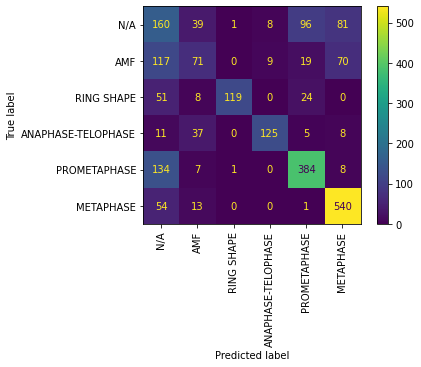

In [10]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm = confusion_matrix(y_true=all_gt_scores, y_pred=all_predictions)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=subclass_names[1:]).plot(xticks_rotation='vertical')


In [11]:
accuracy = np.sum((np.eye(5)*cm[1:,1:]))/np.sum(cm[1:,1:])
print('The accuracy is: ',accuracy)

The accuracy is:  0.855072463768116


Text(0.5, 1.0, 'Non-Hierarchical Classifier, Atypical/Typical decision, AUC=0.681')

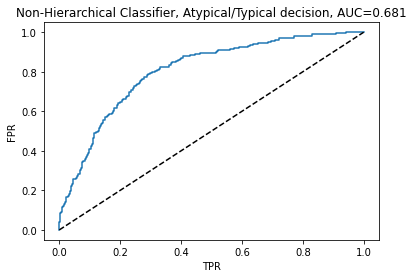

In [12]:
from matplotlib import pyplot as plt
sel = np.stack(all_gt_scores)>=0
from sklearn.metrics import roc_curve
fpr,tpr,thrs = roc_curve(y_score=np.stack(all_prediction_logits)[sel,2], y_true=np.stack(all_gt_scores)[sel]==2)
plt.plot(fpr,tpr)
plt.xlabel('TPR')
plt.plot([0,1],[0,1],'k--')
plt.ylabel('FPR')

from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_score=np.stack(all_prediction_logits)[sel,1], y_true=np.stack(all_gt_scores)[sel]==1)
plt.title('Non-Hierarchical Classifier, Atypical/Typical decision, AUC=%.3f' % auc)



# Evaluate on TUPAC16

TUPAC16 serves as independent hold out test set for our experiment.

In [13]:
db = 'databases_atypia/TUPAC_alternativeLabels_augmented.sqlite'
DB = Database().open(db)
classes = {x:y for x,y,_,_ in DB.getAllClasses() }
databases_directories = [['databases_atypia/TUPAC_alternativeLabels_augmented.sqlite', 'images_mitosis_tupac16/'],
                         ]

annotations_dict_testset={}

class_mapping = { 'Mitose' : 1,
                  'Mitosis - AMF OTHER': 2,
                  'Mitosis - AMF BIPOLAR ASYMMETRIC CAN ALSO HAVE SEGREGATION': 2,
                  'Mitosis - AMF MULTIPOLAR ASYMMETRY CAN ALSO HAVE SEGREGATION': 2,
                  'Mitosis - AMF SEGREGATION ONLY':2,
                  'Mitosis - RING SHAPE (PROMETAPHASE OR METAPHASE)': 3,
                  'Mitosis - NORMAL ANAPHASE-TELOPHASE': 4,
                  'Mitosis - NORMAL PROMETAPHASE': 5,
                  'Mitosis - NORMAL METAPHASE': 6
                }

subclass_names = ['Background', 'Mitosis (no subclass)','AMF', 'RING SHAPE', 'ANAPHASE-TELOPHASE','PROMETAPHASE','METAPHASE']
value_to_class_DB = {y:x for x,y,_,_ in DB.getAllClasses() }
value_to_class = {x:y for x,y in enumerate(subclass_names) }

skipped_classes=[]

for dbfile, folder in databases_directories:
    DB.open(dbfile)
    for uid, fname in DB.listOfSlides()[0:150]:
        fname = folder+fname
        DB.loadIntoMemory(uid)
        annotations_dict_testset[fname] = {}
        for annoI in DB.annotations:
            anno = DB.annotations[annoI]
            if (value_to_class_DB[anno.agreedClass] not in class_mapping): # skip non-mitotic figures
                skipped_classes.append(anno.agreedClass)
                continue
            cls = class_mapping[value_to_class_DB[anno.agreedClass]]
            annotations_dict_testset[fname][annoI] = {'x': [int(anno.x1-25),int(anno.x1+25)], 'y': [int(anno.y1-25), int(anno.y1+25)], 'class': cls}



In [14]:
from src.Dataset import FlatObjectsDataset
from torch.utils.data import DataLoader

testset = FlatObjectsDataset(annotations_dict=annotations_dict_testset,
                                      slide_names=list(annotations_dict_testset.keys()),
                                      path_to_slides='./',
                                      labels=np.arange(1,7),
                                      crop_size=crop_size,
                                      sampling='continuous',
                                      pseudo_epoch_length=2000,
                                      transformations=None)
testset_dl = DataLoader(dataset = testset, batch_size = 8, shuffle = False, 
                        num_workers = 8, collate_fn = testset.collate_fn)

In [15]:
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error
from src.utils import match_scores_targets
from torchmetrics.detection.mean_ap import MeanAveragePrecision
model = model.eval().cuda()


all_gt_scores = []
all_predictions = []
all_prediction_labels = []
all_prediction_logits = []
metrics={}
metric = MeanAveragePrecision(num_classes=2,iou_thresholds=[0.5], class_metrics=True)
metric_per_class = MeanAveragePrecision(num_classes=7,iou_thresholds=[0.5], class_metrics=True)

with torch.no_grad():
    for n, (img,target) in enumerate(tqdm(testset_dl)):
        pred = model(img.cuda(),[{'boxes': y['boxes'].cuda(), 'labels': y['labels'].cuda()} for y in target])[0]
        pred = [{x:y[x].cpu() for x in y } for y in pred]
        for p,t in zip(pred,target):
            boxes = p['boxes'].numpy()
            scores = p['scores'].numpy()
            logits = p['cls_logits'].numpy()
            scl_pred = p['labels'].numpy()
            
            annos = t['boxes'].numpy()
            scl_targets = t['labels'].numpy()
            gt_scores, pred_labels,_,_ = match_scores_targets(boxes,scores,scl_pred,annos,scl_targets, radius = 25, det_th = 0.5)
            gt_scores, pred_scores,_,_ = match_scores_targets(boxes,scores,scores,annos,scl_targets, radius = 25, det_th = 0.5)
            gt_scores, pred_logits,_,_ = match_scores_targets(boxes,scores,logits,annos,scl_targets, radius = 25, det_th = 0.5)
            
            all_gt_scores.extend(gt_scores)
            all_predictions.extend(pred_labels)
            all_prediction_labels.extend(pred_scores)
            all_prediction_logits.extend(pred_logits)

            # update metrics
            targets=[]
            preds=[]
            
            for idx, sample in enumerate(target):
                if sample['boxes'].size(0) == 0:
                    target[idx]['boxes'] = torch.zeros((1, 4), dtype=torch.float32)
                    # === geändert wegen dataset Änderung === #
                    target[idx]['labels'] = torch.tensor([0],dtype=torch.int64)
                # correct indices (since class -1 is represented by 0 in the baseline, as we don't account for unknown subclasses)
                #targets[idx]['labels'] = targets[idx]['labels'] + 1
            # overall metrics compute
                targets.append({'labels' : (sample['labels']>0).int(), 'boxes': sample['boxes']})
                preds.append({'scores': pred[idx]['scores'], 'labels': (pred[idx]['labels']>0).int(),
                              'boxes': pred[idx]['boxes']})
            metric.update(preds, targets)
            metric_per_class.update(pred,target)

metrics = metric.compute()
metrics['per_class'] = metric.compute()
    
#all_gt_scores = np.array(all_gt_scores)

  0%|          | 0/1197 [00:09<?, ?it/s]

In [16]:
metrics

{'map': tensor(0.2764),
 'map_50': tensor(0.2764),
 'map_75': tensor(-1),
 'map_small': tensor(0.),
 'map_medium': tensor(0.5527),
 'map_large': tensor(-1.),
 'mar_1': tensor(0.2669),
 'mar_10': tensor(0.4514),
 'mar_100': tensor(0.4591),
 'mar_small': tensor(0.),
 'mar_medium': tensor(0.9181),
 'mar_large': tensor(-1.),
 'map_per_class': tensor([0.0000, 0.5527]),
 'mar_100_per_class': tensor([0.0000, 0.9181]),
 'per_class': {...}}

### Calculate atypical/typical ROC curve

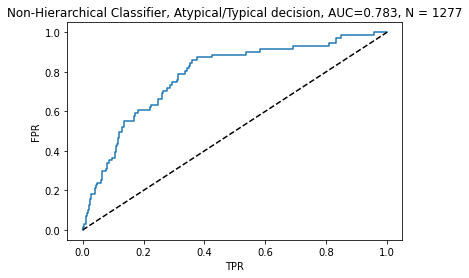

In [17]:
sel = np.stack(all_gt_scores)>0
from sklearn.metrics import roc_curve
fpr,tpr,thrs = roc_curve(y_score=np.stack(all_prediction_logits)[sel,2], y_true=np.stack(all_gt_scores)[sel]==2)
plt.plot(fpr,tpr)
plt.xlabel('TPR')
plt.plot([0,1],[0,1],'k--')
plt.ylabel('FPR')

from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_score=np.stack(all_prediction_logits)[sel,2], y_true=np.stack(all_gt_scores)[sel]==2)
plt.title('Non-Hierarchical Classifier, Atypical/Typical decision, AUC=%.3f, N = %d' % (auc,len(all_prediction_logits)))
plt.savefig('ROC_atypical_typical_flat_run%d.svg' % run)


In [18]:
np.unique(all_gt_scores), np.unique(all_predictions)

(array([1, 2, 3, 4, 5, 6]), array([1, 2, 4, 5, 6]))

### Calculate ROC curve as one vs. rest

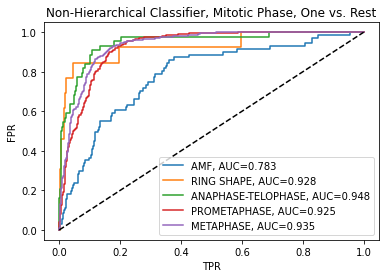

In [19]:
sel = np.stack(all_gt_scores)>0
from sklearn.metrics import roc_curve
for i in np.arange(2,7):
    fpr,tpr,thrs = roc_curve(y_score=np.stack(all_prediction_logits)[sel,i], y_true=np.stack(all_gt_scores)[sel]==i)
    auc = roc_auc_score(y_score=np.stack(all_prediction_logits)[sel,i], y_true=np.stack(all_gt_scores)[sel]==i)
    plt.plot(fpr,tpr, label=f'{subclass_names[i]}, AUC={auc:.3f}')

plt.xlabel('TPR')
plt.plot([0,1],[0,1],'k--')
plt.ylabel('FPR')

from sklearn.metrics import roc_auc_score
plt.legend()
plt.title(f'Non-Hierarchical Classifier, Mitotic Phase, One vs. Rest')

#, AUC={auc:.3f}'  )
plt.savefig('ROC_mitotic_phase_flat_run%d.svg' % run)


In [20]:
torch.save({'cm1':cm, 'all_gt_scores': all_gt_scores,
                      'all_predictions':all_predictions,
            'metrics': metrics,
            }, 'run%d_baseline.pth'% run)